# Examining Air Quality Disparities Among Income Groups
### Neha Vardhaman
My project aims to investigate the relationship between air quality, specifically particulate matter (PM 2.5) levels, and income levels across the United States. By comparing air quality data with income data, I hope to understand whether lower-income communities are exposed to poorer air quality and how this exposure varies geographically. The potential applications of this analysis are providing insights into environmental justice issues and informing policy recommendations for improving air quality in disadvantaged communities.

## Import Required Libraries

In [1]:
%matplotlib inline
import os
from datetime import datetime

# set environment variable needed for basemap
os.environ["PROJ_LIB"] = r'/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1006/share/proj/'

import numpy as np
import mpl_toolkits

import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point

import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cartopy.crs as ccrs # import projection
import cartopy.feature as cf # import features

import json
import folium
import mplleaflet

## Data Sources

### Air Quality dataset
    - Source: NASA SEDAC
    - Details: This dataset contains particulate matter 2.5 (PM 2.5) air quality data for the US 
    between 1998 and 2016 based on NASA SEDAC gridded data. The data is aggregated to states, 
    counties, 116th congressional districts, and 50km hex bins.

In [2]:
# create GeoDataFrame by reading geospatial dataset using Geopandas
pm_gdf = gpd.read_file(os.path.join(r'zip://USA_Particulate_Matter_(PM)_2.5_between_1998-2016.zip')) # zip file downloaded from ArcGIS Hub
# examine dataset
print(pm_gdf.columns)
pm_gdf.head()

Index(['DISTRICTID', 'STFIPS', 'CDFIPS', 'STATE_ABBR', 'NAME', 'LAST_NAME',
       'PARTY', 'SQMI', 'UniqueID', 'TREND_Z', 'TREND_P', 'TREND_BIN',
       'CATEGORY', 'PATTERN', 'PERC_HOT', 'SUM_VALUE', 'MIN_VALUE',
       'MAX_VALUE', 'MEAN_VALUE', 'STD_VALUE', 'MED_VALUE', 'population',
       'populati_1', 'populati_2', 'raceandhis', 'wealth_pci', 'ownerrente',
       'ownerren_1', 'ownerren_2', 'ownerren_3', 'households', 'househol_1',
       'househol_2', 'househol_3', 'populati_3', 'populati_4', 'historical',
       'housingcos', 'housingc_1', 'housingc_2', 'housingc_3', 'homevalue_',
       'END_DATE1_', 'END_DATE11', 'END_DATE_1', 'END_DATE_2', 'END_DATE_3',
       'END_DATE_4', 'END_DATE_5', 'END_DATE_6', 'END_DATE_7', 'END_DATE_8',
       'END_DATE_9', 'END_DAT_10', 'END_DAT_11', 'END_DAT_12', 'END_DAT_13',
       'END_DAT_14', 'END_DAT_15', 'END_DAT_16', 'END_DAT_17', 'GlobalID',
       'PM25Weight', 'geometry'],
      dtype='object')


,DISTRICTID,STFIPS,CDFIPS,STATE_ABBR,NAME,LAST_NAME,PARTY,SQMI,UniqueID,TREND_Z,...,END_DAT_11,END_DAT_12,END_DAT_13,END_DAT_14,END_DAT_15,END_DAT_16,END_DAT_17,GlobalID,PM25Weight,geometry
0,0101,01,01,AL,Bradley Byrne,Byrne,Republican,6224.54,1,-3.988355,...,8.556844,8.564506,8.747178,8.491580,9.001708,8.304233,7.824215,fcac9fa5-fd95-476c-8339-9fcddf548b55,10.014677,MULTIPOLYGON Z (((-9802056.868 3568886.185 0.0...
1,0102,01,02,AL,Martha Roby,Roby,Republican,10260.09,2,-4.268240,...,9.815677,9.463601,9.602893,9.497499,9.512590,9.379804,8.545685,df8cfc50-6b70-4fa9-b51c-c6c27cc31bc7,11.911517,"POLYGON Z ((-9732351.831 3667129.122 0.000, -9..."
2,0103,01,03,AL,Mike Rogers,Rogers,Republican,7725.72,3,-3.848413,...,10.549716,10.423135,9.435550,9.511195,9.789683,9.444472,8.922613,0d64e404-3f00-4464-8ff0-a28110c78510,12.235682,"POLYGON Z ((-9637766.331 4002243.267 0.000, -9..."
3,0104,01,04,AL,Robert B. Aderholt,Aderholt,Republican,9110.37,4,-4.198269,...,10.178303,10.176688,9.240515,9.297165,9.245803,8.973449,8.450169,035dbd12-63b3-460c-84c2-93ee0b40ceb3,12.551858,"POLYGON Z ((-9826632.402 3966915.551 0.000, -9..."
4,0105,01,05,AL,Mo Brooks,Brooks,Republican,3855.41,5,-4.198269,...,10.089426,10.476051,9.127078,9.168177,9.050782,8.649381,8.586039,d6703e28-86c0-411e-abd4-c94746d6bdfd,12.691578,"POLYGON Z ((-9818708.482 4164972.171 0.000, -9..."


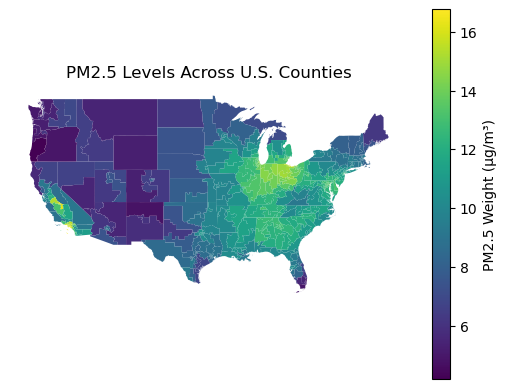

In [3]:
# visualize dataset (chloropleth map)
ax = pm_gdf[~pm_gdf['STATE_ABBR'].isin(['AK', 'HI', 'PR'])].plot(column="PM25Weight", legend=True, legend_kwds={'label': "PM2.5 Weight (µg/m³)", 'orientation': "vertical"})
ax.set_axis_off()
ax.set_title("PM2.5 Levels Across U.S. Counties")
plt.show()

### Income dataset
    - Source: American Community Survey (ACS) 2017-2021
    - Details: This dataset contains the 2017-2021 release of data from the American Community 
    Survey (ACS) 5-year data about Income and Benefits. These are 5-year estimates shown by 
    state and county.

In [4]:
# create GeoDataFrame by reading geospatial dataset using Geopandas
income_gdf = gpd.read_file(os.path.join(r'zip://Income and Benefits 2017-2021_-3932744042133039099.zip')) # zip file downloaded from ArcGIS Hub
# examine dataset
print(income_gdf.columns)
income_gdf.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'POP_DENSIT', 'DP03_0074P', 'DP03_007_1', 'DP02_0001E', 'DP02_0001M',
       'DP03_0052E', 'DP03_0052M', 'DP03_0053E', 'DP03_0053M', 'DP03_0054E',
       'DP03_0054M', 'DP03_0055E', 'DP03_0055M', 'DP03_0056E', 'DP03_0056M',
       'DP03_0057E', 'DP03_0057M', 'INCLT75E_C', 'DP03_0058E', 'DP03_0058M',
       'DP03_0070E', 'DP03_0070M', 'DP03_0072E', 'DP03_0072M', 'DP03_0074E',
       'DP03_0074M', 'HOUSELT75K', 'HOUSELT7_1', 'B19083_001', 'B19083_002',
       'DP05_0071P', 'INCLT75M_C', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,DP03_0072M,DP03_0074E,DP03_0074M,HOUSELT75K,HOUSELT7_1,B19083_001,B19083_002,DP05_0071P,INCLT75M_C,geometry
0,01,001,00161526,0500000US01001,01001,Autauga,Autauga County,AL,Alabama,06,...,72,2298,336,59.2,4.3,0.4499,0.0287,3.0,977.0,"POLYGON ((-9676023.278 3849936.113, -9675929.3..."
1,01,003,00161527,0500000US01003,01003,Baldwin,Baldwin County,AL,Alabama,06,...,179,5839,654,56.0,2.3,0.4572,0.0124,4.7,2103.0,"POLYGON ((-9799296.701 3532731.542, -9798785.8..."
2,01,005,00161528,0500000US01005,01005,Barbour,Barbour County,AL,Alabama,06,...,81,2331,279,78.5,5.0,0.5046,0.0254,4.7,516.0,"POLYGON ((-9545427.259 3713425.370, -9545138.1..."
3,01,007,00161529,0500000US01007,01007,Bibb,Bibb County,AL,Alabama,06,...,122,1198,273,65.3,7.1,0.4532,0.0409,2.8,538.0,"POLYGON ((-9731765.400 3895752.478, -9720255.2..."
4,01,009,00161530,0500000US01009,01009,Blount,Blount County,AL,Alabama,06,...,171,2135,424,64.6,4.0,0.4562,0.0223,9.5,892.0,"POLYGON ((-9680716.730 4009780.421, -9680305.8..."


### Merge datasets
Merging the air quality and income datasets based on their spatial relationships enables analyis of the relationship between the air quality and income in US communities.

In [5]:
# perform a spatial join with GeoPandas on the air quality and income datasets
merged_gdf = gpd.sjoin(pm_gdf, income_gdf, how="inner", predicate="intersects")
# examine dataset
merged_gdf.head()

,DISTRICTID,STFIPS,CDFIPS,STATE_ABBR,NAME_left,LAST_NAME,PARTY,SQMI,UniqueID,TREND_Z,...,DP03_0072E,DP03_0072M,DP03_0074E,DP03_0074M,HOUSELT75K,HOUSELT7_1,B19083_001,B19083_002,DP05_0071P,INCLT75M_C
0,0101,01,01,AL,Bradley Byrne,Byrne,Republican,6224.54,1,-3.988355,...,1194,297,5159,564,63.5,3.2,0.4689,0.0186,6.9,1781.0
224,2804,28,04,MS,Steven M. Palazzo,Palazzo,Republican,8150.91,225,-3.988355,...,1194,297,5159,564,63.5,3.2,0.4689,0.0186,6.9,1781.0
0,0101,01,01,AL,Bradley Byrne,Byrne,Republican,6224.54,1,-3.988355,...,40,56,904,227,70.7,6.7,0.4843,0.0358,3.0,604.0
224,2804,28,04,MS,Steven M. Palazzo,Palazzo,Republican,8150.91,225,-3.988355,...,40,56,904,227,70.7,6.7,0.4843,0.0358,3.0,604.0
0,0101,01,01,AL,Bradley Byrne,Byrne,Republican,6224.54,1,-3.988355,...,2640,421,18262,1029,63.0,1.8,0.4544,0.0082,6.0,2331.0


## Interactive visualization
This interactive visualization allows viewers to hover over a specific region to examine its income and PM2.5 levels.

In [6]:
from folium import GeoJson, GeoJsonTooltip

# filter GeoDataFrame to include only Illinois data
gdf = merged_gdf[merged_gdf['STATE_NAME'] == 'Illinois']
gdf.crs = "EPSG:3857"
# transform coordinate reference system to one that uses latitude and longitude
gdf = gdf.to_crs("EPSG:4326")

# create a Folium map
m = folium.Map(location=[40, -89.5], zoom_start=6)

# create a tooltip that will display specific fields when hovering over the features
tooltip = GeoJsonTooltip(fields=['PM25Weight', 'HOUSELT75K'], aliases=['PM2.5 Weight:', '% Households Income < 75K'])

# add the data and tooltip to the map
geojson = GeoJson(gdf, tooltip=tooltip).add_to(m)

# save the map to an HTML file
m.save('illinois_interactive.html')

## Heatmap
This heatmap visualizes regions with poor air quality (high PM2.5 levels) and low income (high percentage of household incomes under 75,000)

In [7]:
# normalize the data
gdf = merged_gdf[~merged_gdf['STATE_ABBR'].isin(['AK', 'HI', 'PR'])]
gdf['pm2_5_normalized'] = (gdf['PM25Weight'] - gdf['PM25Weight'].min()) / (gdf['PM25Weight'].max() - gdf['PM25Weight'].min())
gdf['income_normalized'] = (gdf['HOUSELT75K'] - gdf['HOUSELT75K'].min()) / (gdf['HOUSELT75K'].max() - gdf['HOUSELT75K'].min())

# create a combined score
gdf['combined_score'] = gdf['pm2_5_normalized'] + gdf['income_normalized']

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/geop

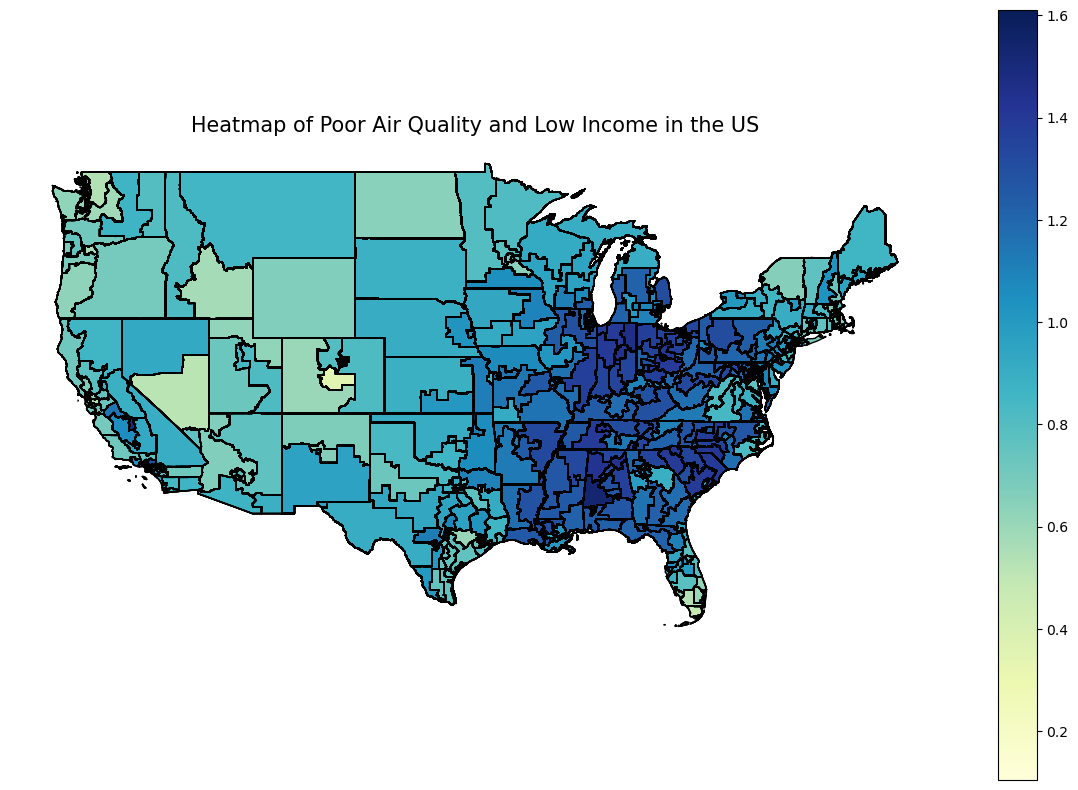

In [8]:
# create a base map of the US
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot the combined score in a chloropleth map
gdf.boundary.plot(ax=ax, linewidth=1, color='black')
gdf.plot(column='combined_score', ax=ax,
         cmap='YlGnBu', legend=True)

ax.set_title('Heatmap of Poor Air Quality and Low Income in the US', fontsize=15)
ax.set_axis_off()

plt.show()

## Statistical Analysis
This section employs some statistical analysis methods to analyze the relationship between air quality and income.

### Scatter plot

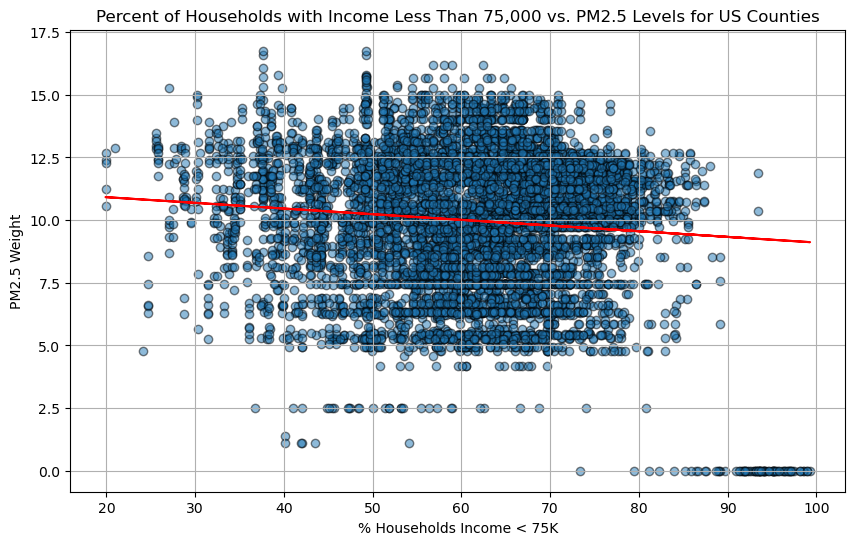

In [9]:
x = merged_gdf['HOUSELT75K']
y = merged_gdf['PM25Weight']

# create scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, edgecolor='k')

# calculate linear trendline
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

# plot trendline
plt.plot(x, trendline, color='red')
plt.title('Percent of Households with Income Less Than 75,000 vs. PM2.5 Levels for US Counties')
plt.xlabel('% Households Income < 75K')
plt.ylabel('PM2.5 Weight')
plt.grid()
plt.show()

### Calculations
These calculations show the relationship between various parts of the datasets.

In [10]:
# correlation coefficient
corr = merged_gdf['PM25Weight'].corr(merged_gdf['HOUSELT75K'])
print("Correlation Coefficient:", corr)

Correlation Coefficient: -0.09912737068829845


In [11]:
# filter counties with higher PM2.5 levels and lower income
filtered = merged_gdf[(merged_gdf['PM25Weight'] >= 12) & (merged_gdf['HOUSELT75K'] >= 0.75)]

# count the number of counties meeting the criteria
num_counties = filtered.shape[0]
print(f"Number of counties with higher PM2.5 levels and lower income: {num_counties}")

Number of counties with higher PM2.5 levels and lower income: 1963


In [12]:
# calculate the proportion of counties meeting the criteria
total_counties = merged_gdf.shape[0]
proportion = num_counties / total_counties * 100

print(f"Proportion of counties with higher PM2.5 levels and lower income: {proportion:.2f}%")

Proportion of counties with higher PM2.5 levels and lower income: 25.54%


In [15]:
# filter GeoDataFrame to include counties meeting the criteria
gdf = filtered
gdf.crs = "EPSG:3857"
# transform coordinate reference system to one that uses latitude and longitude
gdf = gdf.to_crs("EPSG:4326")

# create a Folium map
m = folium.Map(location=[40, -89.5], zoom_start=6)

# create a tooltip that will display specific fields when hovering over the features
tooltip = GeoJsonTooltip(fields=['PM25Weight', 'HOUSELT75K'], aliases=['PM2.5 Weight:', '% Households Income < 75K'])

# add the data and tooltip to the map
geojson = GeoJson(gdf, tooltip=tooltip).add_to(m)

# save map to HTML file
m.save('partial_interactive.html')